In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import binvox_rw
from PIL import Image
import random

In [20]:
device = "cpu"
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
device

'cpu'

In [21]:
class MultiView(nn.Module):
    def __init__(self,img_size,num_views):
        super(MultiView,self).__init__()
        self.img_size = img_size
        self.num_views = num_views

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7,stride=3, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        #22
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        #11
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 400, kernel_size=3, stride=2,padding=1),
            nn.BatchNorm2d(400),
            nn.ReLU()

        )
        #6

        self.FC1 = nn.Linear(400*6*6,200)
        self.FC2 = nn.Linear(400*6*6,200)

    def forward(self,images,batch_size):
        # print("Main forward",images.shape)
        means = torch.zeros(self.num_views,batch_size,200) 
        vars = torch.zeros(self.num_views,batch_size,200) 
        zs = torch.zeros(self.num_views,batch_size,200) 
        for i, image in enumerate(images):
            # image = image
            z_mean, z_log_var = self.single_image_forward(image,batch_size)
            zs[i:] = self.reparameterize(z_mean,z_log_var)
            means[i:] = z_mean
            vars[i:] = z_log_var

        #z_mu= self.combine(means)
        #z_var = self.combine(vars)
        return self.combine(zs), means, vars
    
    def combine(self,input):
        #input should be (num_views,batchsize,z_dimension)
        #output should be (batch_size,z_dimension)
        # if self.combine_type == 'mean':
        output =  torch.mean(input,0)
        # elif self.combine_type == 'max':
        #     output = torch.max(input, 0)[0]
        # elif self.combine_type == 'concat':
        #     pass
        return output
    def single_image_forward(self, x,batch_size):
        # print("inside forward",x.shape)
        out = x.view(batch_size, 3, self.img_size,self.img_size)# (Batch, Number Channels, height, width
        # print(out.shape)
        #print(out.size()) #torch.Size([32, 3, 224, 224])
        out = self.layer1(out)
        #print(out.size())  # torch.Size([32, 64, 54, 54])
        out = self.layer2(out)
        #print(out.size())
        out = self.layer3(out)
        #print(out.size())
        out = self.layer4(out)
        #print(out.size())
        out = self.layer5(out)
        #print(out.size())

        out = out.view(batch_size,-1)#flatten
        #print(out.size())
        z_mean = self.FC1(out.detach())
        z_log_var = self.FC2(out)
        #print(z_mean.size(),z_log_var.size())


        return z_mean, z_log_var

    def reparameterize(self, mu, var):
        # if self.training:
        std = var.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        z =  eps.mul(std).add_(mu)
        return z
        # else:
            # return mu

In [22]:
class Generator(nn.Module):
    def __init__(self,cube_length = 32,latent_dimension = 200):
        super(Generator,self).__init__()
        self.cube_len = cube_length
        self.latent_dim = latent_dimension
        self.init_size = cube_length//16

        padd = (1,1,1) 
        self.lin=nn.Linear(in_features=self.latent_dim,out_features=256*self.init_size*self.init_size*self.init_size )

        self.layer1 = nn.Sequential(
            nn.ConvTranspose3d(self.cube_len*8, self.cube_len*4, kernel_size=4, stride=2, bias=False, padding=padd),
            nn.BatchNorm3d(self.cube_len*4),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose3d(self.cube_len*4, self.cube_len*2, kernel_size=4, stride=2, bias=False, padding=padd),
            nn.BatchNorm3d(self.cube_len*2),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.ConvTranspose3d(self.cube_len*2, self.cube_len, kernel_size=4, stride=2, bias=False, padding=padd),
            nn.BatchNorm3d(self.cube_len),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose3d(self.cube_len, self.cube_len//2, kernel_size=4, stride=2, bias=False, padding=padd),
            nn.BatchNorm3d(self.cube_len//2),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv3d(self.cube_len//2, 1, kernel_size=3, stride=1,padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        out = self.lin(x)

        obj=out.view(x.shape[0],256,self.init_size,self.init_size,self.init_size)

        obj = self.layer1(obj)

        obj = self.layer2(obj)

        obj = self.layer3(obj)

        obj = self.layer4(obj)

        obj = self.layer5(obj)


        return obj
    



In [23]:
class Discriminator(nn.Module):
    def __init__(self,cube_length = 32):
        super(Discriminator,self).__init__()
        self.cube_len = cube_length

        padd = (1,1,1)

        self.layer1 = nn.Sequential(
            nn.Conv3d(1, self.cube_len, kernel_size=4, stride=2, bias=False, padding=padd),
            nn.BatchNorm3d(self.cube_len),
            nn.LeakyReLU(0.01)
        )
        #16
        self.layer2 = nn.Sequential(
            nn.Conv3d(self.cube_len, self.cube_len*2, kernel_size=4, stride=2, bias=False, padding=padd),
            nn.BatchNorm3d(self.cube_len*2),
            nn.LeakyReLU(0.01)
        )
        #8
        self.layer3 = nn.Sequential(
            nn.Conv3d(self.cube_len*2, self.cube_len*4, kernel_size=4, stride=2, bias=False, padding=padd),
            nn.BatchNorm3d(self.cube_len*4),
            nn.LeakyReLU(0.01)
        )
        #4
        self.layer4 = nn.Sequential(
            nn.Conv3d(self.cube_len*4, self.cube_len*8, kernel_size=4, stride=2, bias=False, padding=padd),
            nn.BatchNorm3d(self.cube_len*8),
            nn.LeakyReLU(0.01)
        )
        #2
        self.out=nn.Sequential(nn.Linear(256*((self.cube_len//(2**4))**3),2))

    def forward(self, x):

        out = x.view(-1, 1, self.cube_len, self.cube_len,self.cube_len)

        out = self.layer1(out)

        out = self.layer2(out)

        out = self.layer3(out)

        out = self.layer4(out)

        out=out.view(out.shape[0],-1)

        pred=self.out(out)


        return pred

In [24]:
def readBinvox3DObject(path):
    with open(path, 'rb') as file:
        data = np.float32(binvox_rw.read_as_3d_array(file).data)
    return data

In [25]:
path = "data/train/"
model_3d_file = [name for name in os.listdir(path) if name.endswith('.' + "binvox")][1]
model_2d_files = [name for name in os.listdir(path) if name.startswith(model_3d_file[:-7]) and name.endswith(".png")]
files = random.sample(model_2d_files, 5)
print(model_3d_file)
print(files)

chair_000000287.binvox
['chair_000000287_006.png', 'chair_000000287_008.png', 'chair_000000287_004.png', 'chair_000000287_007.png', 'chair_000000287_002.png']


In [26]:
class ShapeNetMultiviewDataset(Dataset):
    """Custom Dataset compatible with torch.utils.data.DataLoader"""

    def __init__(self, root, image_size,num_views):
        """Set the path for Data.

        Args:
            root: image directory.
            transform: Tensor transformer.
        """
        self.root = root
        self.listdir = os.listdir(self.root)
        self.img_size = image_size
        self.transform_3d = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize([0.5],[0.5])
                ]
            )

        self.transform_2d = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Resize((self.img_size,self.img_size)),
                ]
            )
        self.num_views = num_views

    def __getitem__(self, index):

        model_3d_file = [name for name in self.listdir if name.endswith('.' + "binvox")][index]

        model_2d_files = [name for name in self.listdir if name.startswith(model_3d_file[:-7]) and name.endswith(".png")][:5]
        # model_2d_files = random.sample(model_2d_files, self.num_views)

        volume = readBinvox3DObject(self.root + model_3d_file)
        volume = self.transform_3d(volume)
        
        images = [torch.FloatTensor(self.transform_2d(Image.open(self.root + x ))) for x in model_2d_files]
        return (images, torch.FloatTensor(volume) )

    def __len__(self):
        return len( [name for name in self.listdir if name.endswith('.' + "binvox")])

data/train/


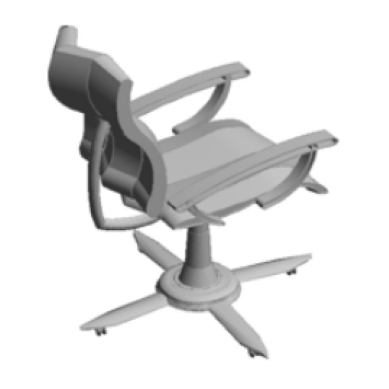

In [27]:
import matplotlib.pyplot as plt
import os
import torch
import matplotlib.gridspec as gridspec
dsets_path = "data/train/"
print(dsets_path)
num_views = 5
train_dataset = ShapeNetMultiviewDataset(dsets_path,256,num_views)
# plt.plot(train_dataset[0][0][0])
plt.imshow(train_dataset[0][0][0].permute(1,2,0))
plt.axis('off')  # Hide axes
plt.show()
# torch.unique(train_dataset[1])

In [28]:
train_dl = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

In [29]:
beta1,beta2 = 0.9,0.99
d_lr = float(0.0002)
g_lr = float(0.0002)
e_lr = float(0.0002)
n_epochs = 1000
batch_size = 32
d_thresh = 0.75
img_size = 256
num_views=5

In [30]:
disc = Discriminator(cube_length=32).to(device)
genr = Generator(cube_length=32,latent_dimension=200).to(device)
enc = MultiView(img_size,num_views)
criterion = nn.CrossEntropyLoss().to(device)

D_optim = optim.Adam(disc.parameters(), lr=d_lr, betas=[beta1,beta2])
G_optim = optim.Adam(genr.parameters(), lr=g_lr, betas=[beta1,beta2])
E_optim = optim.Adam(enc.parameters(), lr=e_lr, betas=[beta1,beta2])

In [31]:
import torch

def generateZ(z_dis,latent_dim,batch_size):
    if z_dis == "norm":
        Z = torch.normal(mean=0, std=0.33, size=(batch_size, latent_dim))
    elif z_dis == "uni":
        Z = torch.randn(size=(batch_size, latent_dim))  
    elif z_dis == "nothing":
        Z = torch.randn(size=(batch_size, latent_dim))
    else:
        print("z_dis is not normal or uniform")
        Z = None  #

    return Z.to(device)

In [32]:
import matplotlib.pyplot as plt
import os
import torch
import matplotlib.gridspec as gridspec

def plot_voxel(ax, voxels, title):
    # Move tensor to CPU and detach for plotting
    
    voxels = torch.Tensor(voxels)
    # Rotate to make the chair upright and face the viewer
    voxels = torch.rot90(voxels, k=1, dims=[0, 2])  # Adjust rotation based on orientation
    voxels = torch.rot90(voxels, k=-1, dims=[0, 1])  # Rotate to face the viewer

    # Apply threshold to get a boolean tensor
    voxels = (voxels >= 0)

    # Plot the voxels
    ax.voxels(voxels, edgecolor='k')
    ax.set_title(title)
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])

def plotFromVoxels(ax,voxels,title):
    voxels = torch.Tensor(voxels)
    voxels = (voxels >= 0)
    # print(voxels.shape)
    z, x, y = voxels.nonzero(as_tuple=True)
    
    ax.scatter(x, y, z, zdir='z', c='red')
    ax.set_title(title)

    # plt.savefig('test')
    # plt.show()



def SavePloat_Voxels(original_data, predicted_data, epoch):
    save_dir = 'voxel_outputs_1'
    os.makedirs(save_dir, exist_ok=True)

    # predicted_data = predicted_data.__ge__(0.5)
    # original_data = original_data.__ge__(0.5)

    fig = plt.figure(figsize=(12, 6))  # Adjusted figure size for two plots
    gs = gridspec.GridSpec(1, 2)  # 1 row, 2 columns for side-by-side plots
    gs.update(wspace=0.05, hspace=0.05)

    # Plot original data on the left
    ax1 = fig.add_subplot(gs[0], projection='3d')
    plotFromVoxels(ax1, original_data, title="Original")

    # Plot predicted data on the right
    ax2 = fig.add_subplot(gs[1], projection='3d')
    plotFromVoxels(ax2, predicted_data, title="Predicted")

    # Save the figure
    plt.savefig(os.path.join(save_dir, f'epoch_{epoch}_comparison.png'), bbox_inches='tight')
    plt.close()

# SavePloat_Voxels(torch.randn((1,32,32,32)),torch.randn((1,32,32,32)),1)
# SavePloat_Voxels(train_dataset[0],train_dataset[1],1)

In [33]:
# torch.autograd.set_detect_anomaly(True)

# def train_one_epoch(e,encoder, generator, discriminator, dataloader,criterion, optimizers, num_views):
#     encoder.train()
#     generator.train()
#     discriminator.train()
    
#     enc_optimizer, gen_optimizer, disc_optimizer = optimizers

    
#     total_vae_loss = 0
#     total_disc_loss = 0
    
#     for batch_idx, (images,model_3D) in enumerate(dataloader):
#         batch_size = model_3D.shape[0]

#         real_labels = torch.ones(batch_size, device=device).type(torch.int64)
#         fake_labels = torch.zeros(batch_size, device=device).type(torch.int64)
        
#         # Move data to device
#         model_3D = model_3D.to(device)
#         # print(type(images))
#         images = torch.stack(images, dim=0)  # Concatenate along an existing dimension
#         # print("train_loop",type(images),images.shape)
#         images = images.view(num_views,batch_size,3,256,256)

        
#         # images = images.to(device)
        
#         # Train VAE (Encoder-Generator)
#         enc_optimizer.zero_grad()
#         gen_optimizer.zero_grad()
        
#         # Forward pass through encoder
#         z_vae ,mu, log_var = encoder(images,batch_size)
        
#         # Generate fake samples
#         # print(z_vae.shape)
#         generated_model = generator(z_vae)
#         # print(generated_model.shape)
        
#         # Calculate VAE losses
#         recon_loss = torch.sum(torch.pow((generated_model - model_3D), 2))
#         kl_loss = 0
#         for i in range(num_views):
#             kl_loss +=  -0.5 * torch.sum(1 + log_var[i] - mu[i].pow(2) - log_var[i].exp())
#         kl_loss
#         kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#         vae_loss = recon_loss + kl_loss
        
#         # vae_loss.backward(retain_graph=True)
#         # gen_optimizer.step()
        
#         total_vae_loss += vae_loss.item()
        
#         # Z = generateZ("nothing",200,batch_size=batch_size).to(device)

#         # fake = generator(Z)
#         d_fake = discriminator(generated_model.detach())
#         g_loss = criterion(d_fake, real_labels)
#         g_loss = g_loss + vae_loss


        
#         g_loss.backward()
#         enc_optimizer.step()
#         gen_optimizer.step()


#         # Train Discriminator
#         disc_optimizer.zero_grad()
        
#         d_real = discriminator(model_3D)
#         d_real_loss = criterion(d_real, real_labels)

#         # fake = generator(Z)
#         d_fake = discriminator(generated_model.detach())
#         d_fake_loss = criterion(d_fake, fake_labels)
        
#         disc_loss = d_real_loss + d_fake_loss
#         disc_loss.backward()
#         disc_optimizer.step()
        
#         total_disc_loss += disc_loss.item()
#         if (e +1)% 2 == 0 and batch_idx == 0:  # Save for the first batch of each epoch
#             # Convert tensors to binvox compatible format
#             original_image = model_3D[0].cpu().detach()  # Original image (first example)
#             predicted_image = generated_model[0][0].cpu().detach() # Predicted image (first example)
#             # print(type(predicted_image),predicted_image)
#             # predicted_image = np.where(predicted_image > 0, 1, 0)
#             # Save the binvox images side by side
#             SavePloat_Voxels(original_image, predicted_image, e+1)

#         # if batch_idx % 100 == 0:
#         #     print(f'Batch [{batch_idx}/{len(dataloader)}], VAE Loss: {vae_loss.item():.4f}, Discriminator Loss: {disc_loss.item():.4f}')
    
#     return total_vae_loss / len(dataloader), total_disc_loss / len(dataloader)

In [34]:
# for e in range(n_epochs):
#     total_vae_loss,total_disc_loss = train_one_epoch(e,enc,genr,disc,train_dl,criterion,(E_optim,G_optim,D_optim),num_views)
#     print(f"--------Epoch {e+1} -------- \n -------- vae_loss : {total_vae_loss} --------\n discriminator_loss : {total_disc_loss} --------")

In [35]:
def train_one_epoch(e, encoder, generator, discriminator, dataloader, criterion, optimizers, num_views, device, 
                    beta=1.0):  # beta for KL loss weighting
    encoder.train()
    generator.train()
    discriminator.train()
    
    enc_optimizer, gen_optimizer, disc_optimizer = optimizers
    total_vae_loss = 0
    total_disc_loss = 0
    total_gen_loss = 0
    
    for batch_idx, (images, model_3D) in enumerate(dataloader):
        batch_size = model_3D.shape[0]
        real_labels = torch.ones(batch_size, device=device).type(torch.int64)
        fake_labels = torch.zeros(batch_size, device=device).type(torch.int64)
        
        # Move data to device
        model_3D = model_3D.to(device)
        images = torch.stack(images, dim=0)
        images = images.view(num_views, batch_size, 3, 256, 256)
        images = images.to(device)  # Important: Move images to device
        
        # ----------------
        # Train Encoder and Generator
        # ----------------
        enc_optimizer.zero_grad()
        gen_optimizer.zero_grad()
        
        # Get latent representations
        z_vae, mu, log_var = encoder(images, batch_size)
        
        # Generate 3D models
        generated_model = generator(z_vae)
        
        # Calculate reconstruction loss
        recon_loss = nn.functional.mse_loss(generated_model.squeeze(1), model_3D, reduction='sum')
        
        # Calculate KL divergence loss
        # Assuming mu and log_var are of shape [num_views, batch_size, latent_dim]
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Adversarial loss for generator
        d_fake_gen = discriminator(generated_model)
        g_loss = criterion(d_fake_gen, real_labels)
        
        # Combined loss
        vae_loss = recon_loss + beta * kl_loss
        total_loss = vae_loss + g_loss
        
        # Backpropagate and optimize
        total_loss.backward()
        enc_optimizer.step()
        gen_optimizer.step()
        
        # ----------------
        # Train Discriminator
        # ----------------
        disc_optimizer.zero_grad()
        
        # Real samples
        d_real = discriminator(model_3D)
        d_real_loss = criterion(d_real, real_labels)
        
        # Fake samples - Need to detach to avoid training generator
        d_fake = discriminator(generated_model.detach())
        d_fake_loss = criterion(d_fake, fake_labels)
        
        # Combined discriminator loss
        disc_loss = (d_real_loss + d_fake_loss) / 2
        
        # Backpropagate and optimize
        disc_loss.backward()
        disc_optimizer.step()
        
        # Update running losses
        total_vae_loss += vae_loss.item()
        total_disc_loss += disc_loss.item()
        total_gen_loss += g_loss.item()
        
        # Logging
        if batch_idx % 10 == 0:
            print(f'Epoch [{e+1}] Batch [{batch_idx}/{len(dataloader)}] '
                  f'VAE Loss: {vae_loss.item():.4f} '
                  f'Gen Loss: {g_loss.item():.4f} '
                  f'Disc Loss: {disc_loss.item():.4f}')
        
        # Save visualizations
        if (e + 1) % 10 == 0 and batch_idx == 0:
            original_image = model_3D[0].cpu().detach()
            predicted_image = generated_model[0][0].cpu().detach()
            SavePloat_Voxels(original_image, predicted_image, e+1)
    
    # Return average losses
    avg_vae_loss = total_vae_loss / len(dataloader)
    avg_disc_loss = total_disc_loss / len(dataloader)
    avg_gen_loss = total_gen_loss / len(dataloader)
    
    return avg_vae_loss, avg_disc_loss, avg_gen_loss

# Helper function for gradient clipping
def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Example usage:
optimizers_config = {
    'encoder': {
        'lr': 0.0001,
        'betas': (0.5, 0.999)
    },
    'generator': {
        'lr': 0.0002,
        'betas': (0.5, 0.999)
    },
    'discriminator': {
        'lr': 0.0002,
        'betas': (0.5, 0.999)
    }
}

def get_optimizers(encoder, generator, discriminator, config=optimizers_config):
    enc_optimizer = torch.optim.Adam(
        encoder.parameters(),
        lr=config['encoder']['lr'],
        betas=config['encoder']['betas']
    )
    gen_optimizer = torch.optim.Adam(
        generator.parameters(),
        lr=config['generator']['lr'],
        betas=config['generator']['betas']
    )
    disc_optimizer = torch.optim.Adam(
        discriminator.parameters(),
        lr=config['discriminator']['lr'],
        betas=config['discriminator']['betas']
    )
    return enc_optimizer, gen_optimizer, disc_optimizer

In [37]:
# # Initialize models and optimizers
# encoder = MultiView().to(device)
# generator = Generator().to(device)
# discriminator = Discriminator().to(device)

optimizers = get_optimizers(enc, genr, disc)
criterion = nn.CrossEntropyLoss()  # or nn.BCEWithLogitsLoss()

# Training loop
for epoch in range(500):
    vae_loss, disc_loss, gen_loss = train_one_epoch(
        epoch, enc, genr, disc,
        train_dl, criterion, optimizers,
        num_views=5, device=device
    )

Epoch [1] Batch [0/3] VAE Loss: 149608.7344 Gen Loss: 9.3193 Disc Loss: 0.0002
Epoch [2] Batch [0/3] VAE Loss: 172760.8438 Gen Loss: 7.0207 Disc Loss: 0.2868
Epoch [3] Batch [0/3] VAE Loss: 167100.2500 Gen Loss: 11.5240 Disc Loss: 0.0454
Epoch [4] Batch [0/3] VAE Loss: 172325.5156 Gen Loss: 13.4277 Disc Loss: 0.0000
Epoch [5] Batch [0/3] VAE Loss: 148032.1250 Gen Loss: 12.9527 Disc Loss: 0.0000
Epoch [6] Batch [0/3] VAE Loss: 155851.3750 Gen Loss: 13.2899 Disc Loss: 0.0000
Epoch [7] Batch [0/3] VAE Loss: 153106.5156 Gen Loss: 12.0961 Disc Loss: 0.0000
Epoch [8] Batch [0/3] VAE Loss: 172624.9219 Gen Loss: 12.8077 Disc Loss: 0.0000
Epoch [9] Batch [0/3] VAE Loss: 135734.4531 Gen Loss: 13.0539 Disc Loss: 0.0000
Epoch [10] Batch [0/3] VAE Loss: 163963.6562 Gen Loss: 12.4416 Disc Loss: 0.0000
Epoch [11] Batch [0/3] VAE Loss: 145560.9844 Gen Loss: 12.3633 Disc Loss: 0.0000
Epoch [12] Batch [0/3] VAE Loss: 153915.1250 Gen Loss: 12.0233 Disc Loss: 0.0003
Epoch [13] Batch [0/3] VAE Loss: 138458

KeyboardInterrupt: 